In [1]:
import bar_chart_race as bcr
import matplotlib.pyplot as plt
import matplotlib

## Datos Covid-19 Colombia

In [2]:
from sodapy import Socrata
import pandas as pd
import numpy as np

In [3]:
def load_colombia_df():
    client = Socrata("www.datos.gov.co", None)  # https://www.datos.gov.co/es/profile/edit/developer_settings   por si no funciona
    results = client.get("gt2j-8ykr", limit=210000)
    results_df = pd.DataFrame.from_records(results)
    return results_df

In [4]:
df_col = load_colombia_df()

In [5]:
def preprocess_df(df):
    df = df.rename(columns={"fecha_diagnostico": "Fecha de diagnóstico",
                            "ciudad_de_ubicaci_n": "ciudad",
                            "fecha_de_notificaci_n": "Fecha de notificacion",
                            "atenci_n": "atencion"})
    
    df["sexo"] = df["sexo"].str.upper()
    df["estado"] = df["estado"].str.upper()
    df["atencion"] = df["atencion"].str.upper()
    df["tipo"] = df["tipo"].str.upper()
    df["edad"] = df["edad"].astype(int)
    
    df["Fecha de diagnóstico"] = pd.to_datetime(df["Fecha de diagnóstico"], errors="coerce")
    df["fecha_recuperado"] = pd.to_datetime(df["fecha_recuperado"], errors="coerce")
    df["fecha_de_muerte"] = pd.to_datetime(df["fecha_de_muerte"], errors="coerce")
    df.loc[df["fis"]=="Asintomático", "estado"] = "ASINTOMATICO"
    df["fis"] = pd.to_datetime(df["fis"], errors="coerce")
    df["tiempo recuperacion"] = df["fecha_recuperado"] - df["fis"]
    df["tiempo recuperacion"] = df["tiempo recuperacion"].dt.days
    
    df["tiempo muerte"] = df["fecha_de_muerte"] - df["fis"]
    df["tiempo muerte"] = df["tiempo muerte"].dt.days
    return df

In [6]:
df_col = preprocess_df(df_col)

In [7]:
def generar_cuenta_colombia(df_data):
    lista = ["Amazonas","Antioquia","Arauca","Atlántico","Bogotá D.C.","Bolívar",
    "Boyacá","Caldas","Caquetá","Casanare","Cauca","Cesar","Chocó",
    "Córdoba","Cundinamarca","Guainía","Guaviare","Huila","La Guajira","Magdalena",
    "Meta","Nariño","Norte de Santander","Putumayo","Quindío","Risaralda","San Andrés y Providencia",
    "Santander","Sucre","Tolima","Valle del Cauca","Vaupés","Vichada"]
    lista = [depto.upper() for depto in lista]
    ceros = [0]*len(lista)
    df_ceros = pd.DataFrame({"NOMBRE_DPT":lista, "cuenta_ceros":ceros})

    # df_data = pd.read_csv("data/Casos1.csv")
    df_data = df_data.rename(columns={"departamento": "NOMBRE_DPT"})
    df_data["NOMBRE_DPT"] = df_data["NOMBRE_DPT"].str.upper()
    df_cuenta = pd.DataFrame(df_data.groupby("NOMBRE_DPT")["id_de_caso"].count()).reset_index().rename(columns={"id_de_caso": "cuenta"})
    
    df_merge = df_ceros.merge(df_cuenta, on="NOMBRE_DPT", how="left")


    df_merge["total"] = df_merge["cuenta"] + df_merge["cuenta_ceros"]
    df_merge = df_merge.drop(["cuenta", "cuenta_ceros"], axis=1)
    nombres_dict = {"BOGOTÁ D.C.": "SANTAFE DE BOGOTA D.C",
                    "VALLE": "VALLE DEL CAUCA"}
    for dept in nombres_dict:
        df_merge = df_merge.replace(dept, nombres_dict[dept])
    df_merge = df_merge.fillna(0)
    df_merge['NOMBRE_DPT'] = df_merge['NOMBRE_DPT'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df_merge = df_merge.replace("NARINO", "NARIÑO")
    return df_merge

In [8]:
df_merge = generar_cuenta_colombia(df_col)

In [9]:
df_col['Fech'] = pd.to_datetime(df_col["Fecha de notificacion"], errors="coerce")

In [10]:
df1 = df_col[['Fech', 'departamento']]

In [11]:
df_dep = pd.pivot_table(df1, index=['Fech'],
                    columns=['departamento'], aggfunc=lambda x: np.count_nonzero(x))

In [12]:
df_dep_ac = df_dep.fillna(0).cumsum()

In [13]:
df_dep_1 = df_dep_ac.fillna(method='ffill')

In [14]:
# Graficar todos los departamentos
#bcr.bar_chart_race(df_dep_1,'corona_col_20.mp4')

In [15]:
import os
from matplotlib import font_manager as fm, rcParams

In [16]:
list(df_dep_1.columns)

['Amazonas',
 'Antioquia',
 'Arauca',
 'Archipiélago de San Andrés Providencia y Santa Catalina',
 'Atlántico',
 'Barranquilla D.E.',
 'Bogotá D.C.',
 'Bolívar',
 'Boyacá',
 'Buenaventura D.E.',
 'Caldas',
 'Caquetá',
 'Cartagena D.T. y C.',
 'Casanare',
 'Cauca',
 'Cesar',
 'Chocó',
 'Cundinamarca',
 'Córdoba',
 'Guainía',
 'Guaviare',
 'Huila',
 'La Guajira',
 'Magdalena',
 'Meta',
 'Nariño',
 'Norte de Santander',
 'Putumayo',
 'Quindío',
 'Risaralda',
 'Santa Marta D.T. y C.',
 'Santander',
 'Sucre',
 'Tolima',
 'Valle del Cauca',
 'Vaupés',
 'Vichada']

In [17]:
df_dep_1 = df_dep_1.rename(columns={'Archipiélago de San Andrés Providencia y Santa Catalina':'San Andrés', 'Santa Marta D.T. y C.':'Santa Marta', 'Norte de Santander':'Norte Santander', 'Cartagena D.T. y C.':'Cartagena'})

In [18]:
df_dep_1.iloc[::2]

departamento,Amazonas,Antioquia,Arauca,San Andrés,Atlántico,Barranquilla D.E.,Bogotá D.C.,Bolívar,Boyacá,Buenaventura D.E.,...,Putumayo,Quindío,Risaralda,Santa Marta,Santander,Sucre,Tolima,Valle del Cauca,Vaupés,Vichada
Fech,,,,,,,,,,,,,,,,,,,,,
2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-07,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2020-03-09,0.0,6.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2020-03-11,0.0,14.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
2020-03-13,0.0,18.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,2.0,0.0,0.0,8.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-19,4916.0,36608.0,344.0,60.0,38890.0,51628.0,135782.0,3574.0,1304.0,3852.0,...,700.0,428.0,2154.0,5646.0,4050.0,8994.0,3716.0,32854.0,122.0,4.0
2020-07-21,4916.0,36658.0,344.0,60.0,38912.0,51656.0,135784.0,3576.0,1304.0,3856.0,...,700.0,428.0,2154.0,5646.0,4074.0,9004.0,3716.0,32892.0,122.0,4.0
2020-07-24,4916.0,36662.0,344.0,60.0,38912.0,51656.0,135786.0,3576.0,1304.0,3856.0,...,700.0,428.0,2154.0,5646.0,4074.0,9004.0,3716.0,32892.0,122.0,4.0


In [19]:
colores = ['#424630','#d56c48','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630','#424630']
len(colores)

58

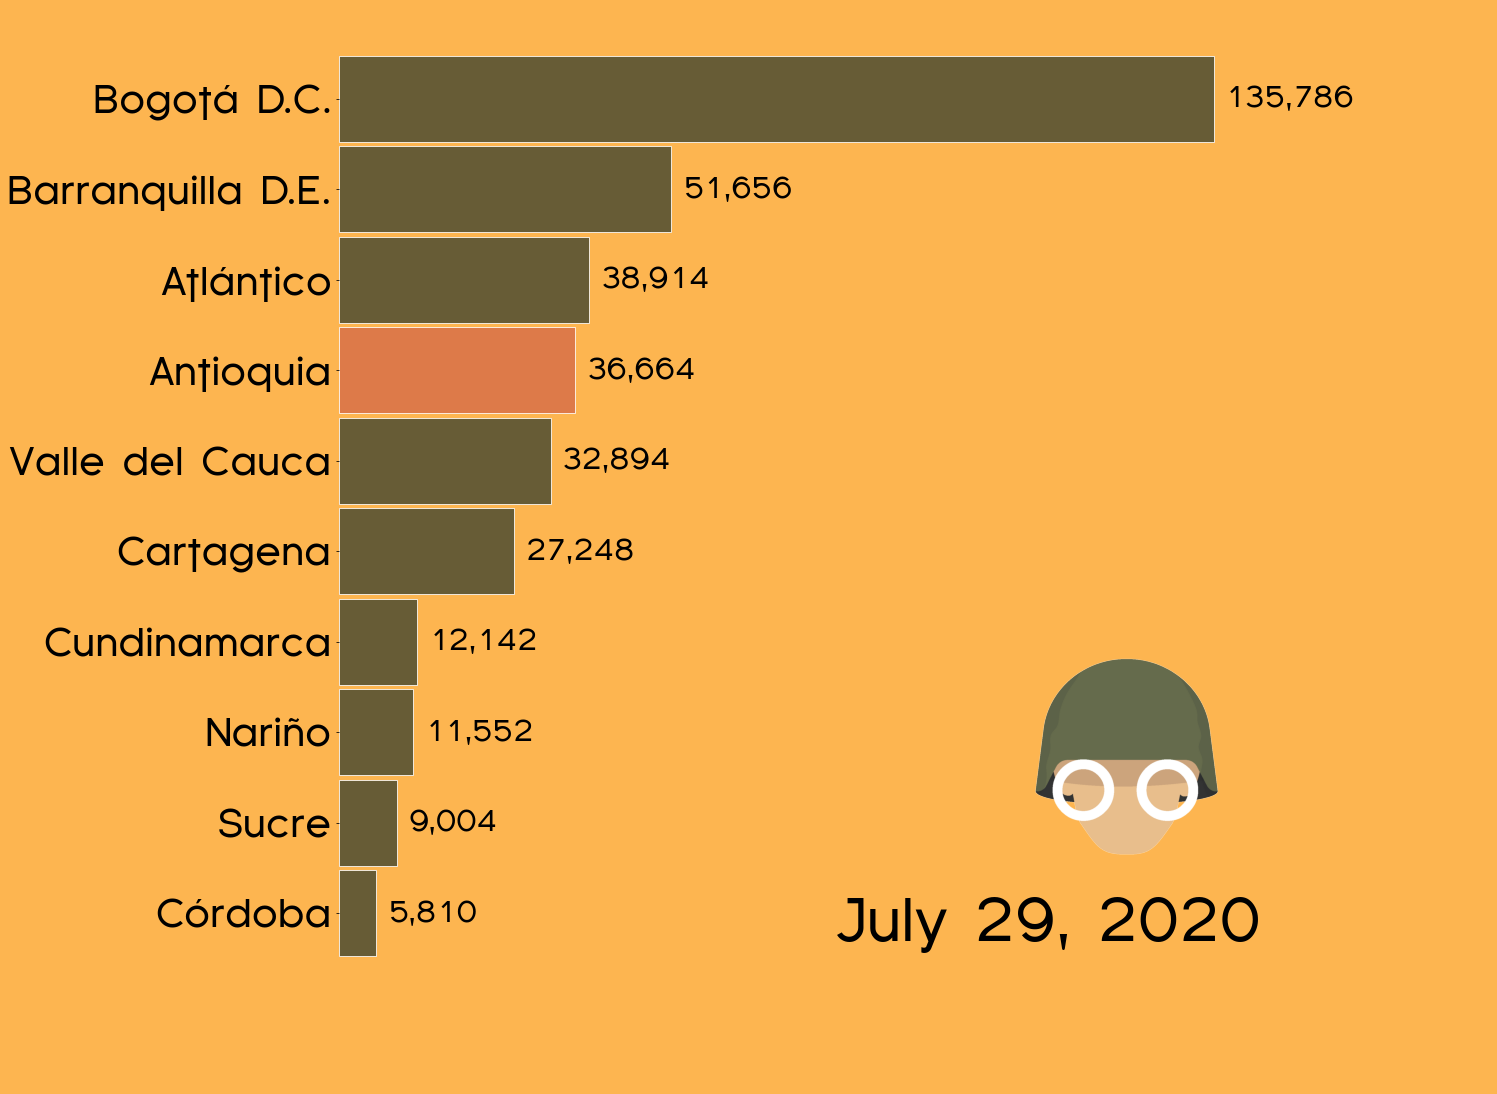

In [20]:
fpath = os.path.join(rcParams["datapath"], "../../../styles/Florsn01.ttf")
prop = fm.FontProperties(fname=fpath)
fig, ax = plt.subplots(figsize=(20, 15), facecolor=(253/255, 181/255, 80/255, 1))
ax.set_facecolor((253/255, 181/255, 80/255, 1))
ax.set_xlabel("", fontsize=25)
ax.set_ylabel("", fontsize=25)
plt.rcParams['font.size'] = 25
plt.box(False)
plt.grid(False)
plt.rcParams['axes.grid'] = False
plt.xticks([])
plt.subplots_adjust(left=0.28, right=1.08, top=1, bottom=0)



img = plt.imread("../../../styles/cara1-01.png")
newax = fig.add_axes([0.61, 0.15, 0.3, 0.3], anchor='NE', zorder=-1)
newax.imshow(img)
newax.axis('off')

#plt.rcParams['font.family'] = 'Florencesans'
#for tick in ax.get_xticklabels():
#    tick.set_fontname("Florencesans")
'''
#plt.rcParams['font.family'] = 'Florencesans'
for tick in ax.get_xticklabels():
    tick.set_fontname("Florencesans")
    
'''


bcr.bar_chart_race(df_dep_1.iloc[::2], '../../../outputs/covid_dep_ago22.mp4', colors=colores, fig=fig, n_bars=10, #title={'size':10, 'family':'Florencesans', 'label': 'Covid-19 en Colombia', 'color': '#424630'},
                   tick_label_font={'size':40, 'family':'Florencesans'}, tick_template='{x:10.2f}', bar_label_font={'size':30, 'family':'Florencesans'},
                   period_label={'size': 60, 'family':'Florencesans', 'x': .8,'y': .15, 'ha': 'right', 'va': 'center'}, period_length=400, shared_fontdict={'family':'Florencesans'}, filter_column_colors=True, period_template='%B %d, %Y')


## Corona paises

In [4]:
df_c = pd.read_csv('../../../data/owid-covid-data.csv').fillna(0)

In [6]:
#list(df_c.columns)

['iso_code',
 'continent',
 'location',
 'date',
 'total_cases',
 'new_cases',
 'total_deaths',
 'new_deaths',
 'total_cases_per_million',
 'new_cases_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'total_tests',
 'new_tests',
 'total_tests_per_thousand',
 'new_tests_per_thousand',
 'new_tests_smoothed',
 'new_tests_smoothed_per_thousand',
 'tests_units',
 'stringency_index',
 'population',
 'population_density',
 'median_age',
 'aged_65_older',
 'aged_70_older',
 'gdp_per_capita',
 'extreme_poverty',
 'cvd_death_rate',
 'diabetes_prevalence',
 'female_smokers',
 'male_smokers',
 'handwashing_facilities',
 'hospital_beds_per_thousand',
 'life_expectancy']

In [7]:
df_casos = df_c[['date','location','total_cases','total_deaths']]

In [8]:
df_casos

,date,location,total_cases,total_deaths
0,2019-12-31,Afghanistan,0.0,0.0
1,2020-01-01,Afghanistan,0.0,0.0
2,2020-01-02,Afghanistan,0.0,0.0
3,2020-01-03,Afghanistan,0.0,0.0
4,2020-01-04,Afghanistan,0.0,0.0
...,...,...,...,...
30006,2020-02-28,International,705.0,4.0
30007,2020-02-29,International,705.0,6.0
30008,2020-03-01,International,705.0,6.0
30009,2020-03-02,International,705.0,6.0


In [9]:
df_cas = df_casos.pivot_table('total_cases', ['date'], 'location').fillna(0)

In [10]:
df_cas

location,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Western Sahara,World,Yemen,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-09,33653.0,3106.0,17348.0,855.0,386.0,3.0,73.0,83413.0,29820.0,105.0,...,974.0,11259.0,12.0,8010.0,369.0,519.0,12017661.0,1318.0,1895.0,885.0
2020-07-10,33908.0,3188.0,17808.0,855.0,396.0,3.0,73.0,90680.0,30346.0,105.0,...,977.0,11723.0,12.0,8372.0,369.0,519.0,12246269.0,1356.0,1895.0,926.0
2020-07-11,34366.0,3278.0,17808.0,855.0,458.0,3.0,74.0,94047.0,30903.0,105.0,...,985.0,12206.0,12.0,8803.0,370.0,519.0,12476028.0,1380.0,1895.0,942.0


In [11]:
df_sram = df_c.loc[df_c['continent'] == 'South America']

In [12]:
df_sa = df_sram.pivot_table('total_deaths', ['date'], 'location').fillna(0)

In [13]:
df_sa

location,Argentina,Bolivia,Brazil,Chile,Colombia,Ecuador,Falkland Islands,Guyana,Paraguay,Peru,Suriname,Uruguay,Venezuela
date,,,,,,,,,,,,,
2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-09,1654.0,1577.0,67964.0,6573.0,4527.0,4900.0,0.0,16.0,20.0,11133.0,17.0,29.0,75.0
2020-07-10,1707.0,1638.0,69184.0,6682.0,4714.0,4939.0,0.0,16.0,20.0,11314.0,17.0,29.0,80.0
2020-07-11,1749.0,1702.0,70398.0,6781.0,4925.0,4983.0,0.0,16.0,20.0,11500.0,18.0,29.0,83.0


In [14]:
bcr.bar_chart_race(df_sa,'corona_sur_america_muertes.mp4')

In [115]:
df_eur = df_c.loc[df_c['continent'] == 'Europe']
df_eu = df_eur.pivot_table('total_cases', ['date'], 'location').fillna(0)
bcr.bar_chart_race(df_eu,'corona_europa.mp4')

In [116]:
df_eur = df_c.loc[df_c['continent'] == 'Europe']
df_eu = df_eur.pivot_table('total_cases', ['date'], 'location').fillna(0)
bcr.bar_chart_race(df_eu,'corona_europa1.mp4')

KeyboardInterrupt: 